##### Задача
Сравнить средние между тестом и контролем методом бутстрап и с применением критерия Манна-Уитни

In [21]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import mannwhitneyu
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [22]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/389496/hw_bootstrap.csv', sep=';', decimal=',')

In [23]:
df = df.drop(columns=['Unnamed: 0'])

In [24]:
df_treatment = df.query('experimentVariant == "Treatment"').value.reset_index(drop=True)
df_control = df.query('experimentVariant == "Control"').value.reset_index(drop=True)

In [13]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [25]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

#### Проверка гипотезы с применением бутстрапа

100%|██████████| 1000/1000 [00:00<00:00, 4057.52it/s]


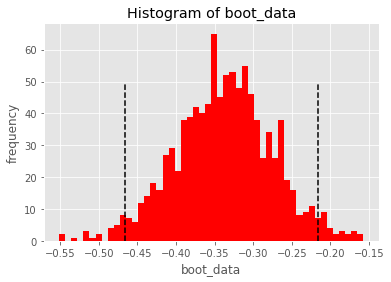

In [26]:
booted_data = get_bootstrap(df_control, df_treatment) 

In [27]:
booted_data["p_value"] 

6.797557536321783e-08

In [28]:
booted_data["quants"] 

,0
0.025,-0.465641
0.975,-0.215684


#### Проверка гипотезы с применением критерия Манна-Уитни

In [29]:
stat, p = mannwhitneyu(df_control, df_treatment)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=9508.000, p=0.003


#### Выводы

На основании результатов бутстрап можно сделать вывод, что с вероятностью 95% разница средних между контрольной выборкой и тестовой выборкой лежит в интервале от -0.461455 до -0.217737. Данные значения доверительного интервала позволяют сделать вывод о значимости различий. 
При применении критерия Манна-Уитни был получен p-value=0.003, что также позволяет отклонить нулевую гипотезу о равенственстве средних (p < 0.05).
Таким образом, при применении обоих критериев нулевая гипотеза была отклонена. 
Однако, p-value в бутстрап сильно меньше p-value, полученного u-тестом. Скорее всего, это связано с тем, что критерий Манна-Уитни проверяет гипотезу не равенстве средних значений, а о равенстве распределений, тогда как в бутстрап методе мы сравниваем именно средние значения. Это значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки.